In [76]:
from getdata import GetDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [103]:
data_orig,target = GetDataset(CreateDataFrame=True).Outputdata()

In [104]:
#Interpolacion para que los datos en x1 sean x distantes
x = np.linspace(data_orig[0][0].min(),data_orig[0][0].max(),900)
temp = np.zeros((data_orig.shape[0],900))
for i in range(data_orig.shape[0]):
    temp[i,:] = np.interp(x,data_orig[i][0][:-1],data_orig[i][1][:-1])

In [105]:
# Creacion de arreglos matriciales 30x30 2 channels
np.sqrt(901)
dim = int(np.sqrt(temp.shape[1]))
data = np.zeros((temp.shape[0],dim,dim,2))
for i in range(data.shape[0]):
    data[i,:,:,0] = temp[i].reshape((1,dim,dim))
    data[i,:,:,1] = np.gradient(temp[i]).reshape((1,dim,dim))

In [107]:
torch.manual_seed(42)
shuffle_idx = torch.randperm(3090, dtype = torch.long)
data_shuffle = data[shuffle_idx]
target_shuffle = target[shuffle_idx]
shuffle_idx

tensor([2082, 2966, 2862,  ...,  847, 2232, 1707])

In [180]:
target_shuffle[0]

2.08

In [182]:
train_input, train_target = data_shuffle[:2472,:,:,:], target_shuffle[:2472]
val_input, val_target = data_shuffle[2472:2781,:,:,:], target_shuffle[2472:2781]
test_input, test_target = data_shuffle[2781:,:,:,:], target_shuffle[2781:]

In [183]:
val_target[0]

3.32

In [184]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [185]:
train_input = torch.tensor(train_input, dtype = torch.float, device=device)
train_target = torch.tensor(train_target, dtype = torch.float, device=device)

test_input = torch.tensor(test_input, dtype = torch.float, device=device)
test_target = torch.tensor(test_target, dtype = torch.float, device=device)

val_input = torch.tensor(val_input, dtype = torch.float, device=device)
val_target = torch.tensor(val_target, dtype = torch.float, device=device)

In [186]:
train_input = train_input.permute(0,3,1,2)
test_input = test_input.permute(0,3,1,2)
val_input = val_input.permute(0,3,1,2)


In [187]:
train_input.shape
val_input.shape
test_input.shape

torch.Size([309, 2, 30, 30])

In [188]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm
import math
from torchsummary import summary

class Lineal_Net(nn.Module):
    def __init__(self, criterion, optimizer):
        super(Lineal_Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=(1,5), stride=5, padding=0) #30x6
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1,3), stride=3, padding=0) #30x2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1,2), stride=1, padding=0) #30x1
        self.fc1 = nn.Linear(64 * 2 * 1, 64)
        self.fc2 = nn.Linear(64,1)

        self.criterion = criterion
        self.optimizer = optimizer


    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = F.max_pool2d(x, kernel_size=2, stride=2)
        #x = x.view(-1, 64 * 30 * 1)
        x = x.contiguous() 
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def train(self, x, y, epochs, lr, batch_size):

        optimizer = self.optimizer(self.parameters(), lr=lr)
        epoch_loss = []
        total_batches = math.floor(y.shape[0]/batch_size)

        for e in range(epochs):
            pbar = tqdm(total= total_batches, desc=f'Epoch {e+1}/{epochs}', position=0, leave=True)
            acc_loss = 0.0
            shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)
            batches = torch.split(shuffle_idx, batch_size)
            
            for batch in batches:

                input_batch = x[batch]
                target_batch = y[batch]

                output = self.forward(input_batch)

                # Calcular la pérdida
                loss = self.criterion(output.float(), target_batch.float())

                # Guardamos la perdida del batchs
                acc_loss += loss.item()
                
                # Realizamos el backpropagation y la actualización de los parámetros
                optimizer.zero_grad()  # Necesario porque pytorch acumula los gradients en lugar de reemplazarlos en cada iteracion
                loss.backward()

                optimizer.step()

                pbar.set_postfix({'Loss': loss.item()})
                pbar.update(1)
                
            epoch_loss.append(acc_loss)
            avg_loss = acc_loss / batch_size
            pbar.set_postfix({'Average Loss': avg_loss})
            pbar.close()
            
        return epoch_loss
    
model = Lineal_Net(nn.MSELoss(), optim.Adam)
model.to(device)
loss = model.train(train_input, train_target, epochs=100, lr=0.01, batch_size=100)

Epoch 1/100:   0%|          | 0/24 [00:00<?, ?it/s]c:\Users\hecto\miniconda3\envs\RNN\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100:  96%|█████████▌| 23/24 [00:00<00:00, 207.99it/s, Loss=0.72] c:\Users\hecto\miniconda3\envs\RNN\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100: 25it [00:00, 205.28it/s, Average Loss=1.98]                 
Epoch 2/100: 25it [00:00, 217.90it/s, Average Loss=2.11]                 
Epoch 3/10

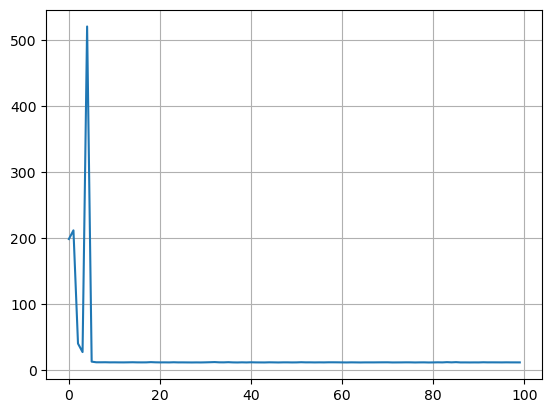

In [189]:
plt.plot(range(100), loss)
plt.grid(True)

In [175]:
val_input[0:1,:,:,:].shape

torch.Size([1, 2, 30, 30])

In [190]:
model.forward(val_input[0:10,:,:,:])

tensor([[2.5730],
        [2.5712],
        [2.5710],
        [2.5721],
        [2.5718],
        [2.5745],
        [2.5748],
        [2.5739],
        [2.5722],
        [2.5725]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [191]:
val_target[1:10]

tensor([2.0700, 3.3700, 2.8500, 1.9700, 3.1900, 3.2600, 2.5200, 2.2200, 2.1700],
       device='cuda:0')